# What Musical Notes Make Up That Sound?
#### Project by: Kurtis Wiles

## Objective
I will write code that can determine the notes that make up any sound and the key the notes belong to.

## Introduction
With my experience in playing music, I decided to do a project on detecting the frequencies of musical notes. This is possible because a standard set of frequencies is used to define the musical notes of any typical piece of music. It is what allows many different instruments to be played together in harmony despite producing distinct sounds. I will be using this fact to determine the notes that make up the sounds from recordings of my instruments. The code I write will also be guessing the key of a piece of music after determining the notes that were played throughout.

In [41]:
import numpy as np
import pylab as py
from numpy.fft import fft, fftfreq
import matplotlib.pyplot as plt

## Importing Data
To begin, I first need to import the audio data. I will be using Audacity, a free open source audio editing software, to turn short audio recordings into text files for analysis. https://www.audacityteam.org/ 

When analyzing data from waves, it is important to check that the sampling rate is high enough for the frequencies that will be measured. The highest frequency note on a standard piano is about 4200Hz, making the Nyquist sampling rate 8400Hz. To ensure an accurate Fourier analysis, a minimum of 32000Hz (or approximately 4x the Nyquist sampling rate) will be used for the sampling rate in all of my recordings.

Now to begin the analysis, a function that handles the initial data processing will be created. The function will import the text file produced by Audacity and put the data into two arrays: one for times and one for amplitudes. It will then split the arrays into segments based on an input value for the desired number of segments per second of audio. The purpose for segmenting the arrays will become clear later.

In [42]:
def audio_segmenter(data, segments_per_second): #set approximate number of segments per second of audio
    wave = np.loadtxt(data) #load data and put into arrays
    times = wave[:,0] #times assumed to be in seconds
    amplitudes = wave[:,1]
    
    audio_length = times[-1] - times[0]
    
    amp_segments = np.array_split(amplitudes,round(segments_per_second*audio_length)) #split amplitudes into segments  
    time_segments = np.array_split(times,round(segments_per_second*audio_length)) #split time for time data

    return amp_segments, time_segments #returns arrays containing segments

## Fourier Transform

Fourier transforms can reveal which sinusoidal functions best represent or makeup a given periodic function or data set. In other words, the Fourier transfom can identify which combinations of sines and cosines will produce a given wave. This is important for identifying notes from a sound wave because information about the frequencies that make up the sound can be extracted through this process. 

Thus, the purpose of segmenting the audio data was to perform Fourier transforms throughout the recording. It is necessary to do transforms on very short segments of music because different notes are often played in rapid succession. Performing a Fourier transfrom on the entire recording of music would not preserve any information about when the notes were played and would likely struggle to find all of the different notes that were heard throughout.

The Fourier transform is given by:

$$
	A(f) = \int_{-\infty}^\infty a(t) e^{-2\pi i f t} dt = \int_{-\infty}^\infty a(t) e^{-i \omega t} dt
$$

However, I will be using the Fast Fourier Transform (FFT) function from numpy because it is significantly faster to compute.

Because I am not interested in the phase or negative frequencies of the sound waves, I choose to use the power spectrum of the FFT. The power spectrum is simply the absolute value squared of the transform and will simplify the process of locating peak frequencies. To implement this into code, I will create a function that takes one of the segments from the audio segmentor and outputs the power spectrum from the FFT.  


In [43]:
def segment_powerfft(amp_segment, time_segment): #inputs a segment of amplitude and time
    t = time_segment
    dt = (t[-1] - t[0]) / (len(t) - 1) #finds average dt to account for data sets where times may be rounded
    
    A = np.abs(fft(amp_segment))**2 #power specturm fft
    freq = fftfreq(len(amp_segment),dt)    
    
    # Now I will remove the negative frequencies from the fft.
    # Because numpy puts the positive frequencies before the negative ones,
    # the following loop determines the index that negative frequencies start at.
    
    neg = 0
    for i,f in enumerate(freq): #determines which index starts negative frequencies 
        if np.sign(f) < 0:
            neg = i
            break
    
    freq = freq[:neg-1] #removes values associated with negative frequencies 
    A = A[:neg-1]
    
    return A, freq #returns the power specturm fft without negatives

## Graphing

With these two functions, it is possible to plot a segment of audio and it's FFT to examine the results. I will create a function that does this automatically to make observing any segmet of audio data quick and easy.

In [44]:
def segment_graph(data, segments_per_second, segment_number, f_max): # produces a graph of the wave and fft of the segment
    i = segment_number - 1
    
    amp_segments, time_segments = audio_segmenter(data, segments_per_second) #segments the data
    A, freq = segment_powerfft(amp_segments[i], time_segments[i]) #performs powerfft on the desired segment

    fig, (wave,fft) = py.subplots(2,1, figsize=(7,7)) #plots both for observation
    fft.plot(freq,A)
    fft.set_xlim(0,f_max) #the input f_max determines the limit on the x axis 
    fft.set_xlabel('Frequency (Hz)')
    fft.set_ylabel('Power Spectrum')
    wave.plot(time_segments[i],amp_segments[i])
    wave.set_xlabel('Time (s)')
    wave.set_ylabel('Amplitude')
    wave.set_title('Wave and Power Specturm | Segment: '+str(segment_number))
    
    return

* Here is an example from a recording of an E7 chord on my guitar:

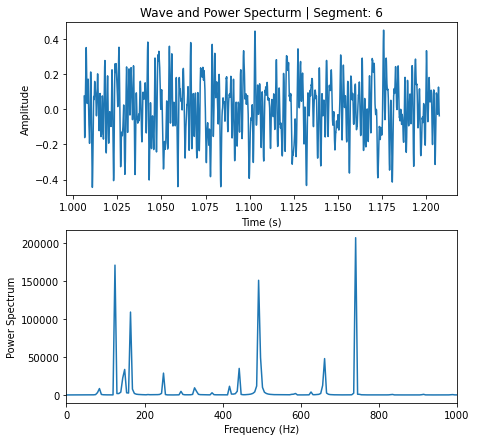

In [45]:
segment_graph('E7.txt', 5, 6, 1000)
# where the segments per second is approximately 5, the graph will show the 6th segment, and the f max will be 1000Hz

## Detecting Peaks

Looking at the graph of the FFT, there are clear spikes at a few particular frequencies. I would like to create a record of frequencies associated with those peaks so that I can check if they are notes. To do this, a function will be created that takes the FFT data and an input for the sensitivity of detecting a peak and will output a list of the frequencies associated with the detected peaks.

Because it will likely be necessary to adjust the sensitivity on a case by case basis, I made the condition for detecting a peak in the FFT be a value that exceeds the sensitivity input value multiplied by the mean value of the transform.

In [46]:
def prominent_freq(A, freq, sensitivity): #inputs fft
    prom_freq = []
    detection = np.mean(A)*sensitivity
    for i,a in enumerate(A): 
        if a > detection: #if a high value is found, record its frequency
            prom_freq.append(freq[i]) 
    
    return prom_freq #returns detected frequencies

* Here is an example of the prominent frequencies from the previous graph with the detection condition being 100x larger than the average:

In [47]:
amp_segments1, time_segments1 = audio_segmenter('E7.txt', 5)
A1, freq1 = segment_powerfft(amp_segments1[5], time_segments1[5])
print(prominent_freq(A1, freq1, 100))

[124.22812393694242, 149.0737487243309, 163.981123596764, 248.45624787388485, 442.25212121551505, 491.943370790292, 496.9124957477697, 660.8936193445337, 740.3996186641768]


Note: this has the possibility to double count a frequency, as can be seen with 492Hz; however, this will not affect the analysis.

## Theory for Determining Notes 

Now that I have obtained the prominent frequenceis that make up the sound wave, I need to find out which notes they correspond to. For this, is it necessary to understand how notes are assigned frequencies. 

By far, the most common system used for assigning frequencies to notes is the twelve tone equal temperament (12TET) system. With 12TET, the frequency gaps between notes are based on a logarithmic scale and the frequencies of notes an octave apart (where an octave consists of 12 notes) are double or half depending on whether the octave is higher or lower. This creates a convenient system where the frequency of every note can be definied from the frequency of a single note. 

The note that is used to define the frequencies is A4 (the A note in octave 4). A4 is internationally recognised to have a frequency of 440Hz, thus defining the frequency of every other note. However, there are pieces of music that use other frequences for A. With that in mind, I will make it possible to change the frequency of A (causing every note to have a different frequency) for the case where the music is in a different tuning.

The equation that can determine the frequency of any note, $P_n$, using 12TET is:

$$
    P_n = P_a \cdot 2^{(n-a)/12}
$$

Where $P_a$ is the known frequency of any note $a$.

In the case of A4, it is the $49^{th}$ note on the piano and has a frequency of 440Hz, so the function used will be:

$$
    P_n = 440 \cdot 2^{(n-49)/12}
$$

References:
* http://hyperphysics.phy-astr.gsu.edu/hbase/Music/et.html#c1
* https://en.wikipedia.org/wiki/Equal_temperament

Using this equation, I will create an array with the ideal frequecies of all 88 notes on a piano. I have chosen to limit my scope of determining notes to only the 88 keys on a standard piano to make the process of storing and graphing notes simpler. Next I will make a function that inputs a frequency and compares it to all of the notes to find if it falls within a tolerace value of being a certain note. If a note is found, the function will return an array of size 88 with a 1 in the position where the note should be and zeros everywhere else.

In [48]:
A_Pitch = 440 #basis for all notes

def key_frequency(key_number): #ouputs the frequency of any key on a piano from 1 to 88
    return 2**((key_number-49)/12) * A_Pitch

actual_notes = np.zeros(88)
for n in range(88): #fills an array with the actual frequencies of the notes
    actual_notes[n] = key_frequency(n+1)

def note_checker(f, freq_tolerance): #checks input frequencies against note frequencies 
    #tolerance should be set lower than 0.03 because the ratio between neighboring notes is 1.059
    
    note = np.zeros(88)
    for n,f_actual in enumerate(actual_notes):
        if abs(f_actual - f) < f_actual * freq_tolerance: #f must be within a percentage of actual
            note[n] = 1
            break
    
    return note

Note: I decided to use tolerace as a percentage of the actual note because the gaps between notes increases significantly as the frequency increases.
* Here is an example of one of the prominent frequencies from the E7 recording. As can be seen, the frequency of 442.3Hz is very close to 440Hz and returns an array with a 1 in the 49th position representing A4.

In [49]:
print(note_checker(442.25212121551505, 0.01)) # 1% tolerance is used

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


## Putting it All Together 

Now that all of the parts have been created, I will put them all together. I will make a function that inputs the data, the segments per second, the frequency tolerance, and the sensitivity, then outputs a 2D array with every note that is dected along with the times of each segment. 

In [50]:
def note_analyser(data, segments_per_second, freq_tolerance, sensitivity): #determines the notes in a recording 
    
    amp_segments, time_segments = audio_segmenter(data, segments_per_second) #splits the data into multiple arrays
    
    note_record = np.zeros((len(amp_segments),88)) #2D array to store notes    
    time_record = np.zeros(len(time_segments)) #1D array to store times
    
    for x in range(len(amp_segments)): #loop through the segments
        A, freq = segment_powerfft(amp_segments[x], time_segments[x]) #fft each segment
        prom_freq = prominent_freq(A, freq, sensitivity) #detect prominent frequencies in segment
        
        for i,f in enumerate(prom_freq): #loop through prominent frequencies to determine notes
            note_record[x,:] = note_record[x,:] + note_checker(f, freq_tolerance) #store the notes in the 2D array
        
        time_record[x] = time_segments[x][0] #stores initial time of each segment  
    
    return note_record, time_record #returns 2D array with notes detected in each segment

* To turn the large 2D array the function outputs into a more readable format, I created a function that will read through the array and print the notes with the appropriate octave number, time, and segment.

In [51]:
def note_print(note_record, time_record): #prints a list of detected notes from the 2D array
    
    for a,array in enumerate(note_record): #loop through each row in the array (representing each segment)
        
        out = []           
            
        for i in range(8): #loop that checks all 88 notes in order and appends any that are found
            if array[0+int(i*12)] > 0: out.append( 'A' + str(i) )
            if array[1+int(i*12)] > 0: out.append( 'A#' + str(i) )
            if array[2+int(i*12)] > 0: out.append( 'B' + str(i) )
            if array[3+int(i*12)] > 0: out.append( 'C' + str(i+1) ) # i+1 because octave one begins at the 4th note, C 
            if i == 7: break #to stop at note 88 (C8 is the only note from the 8th octave)
            if array[4+int(i*12)] > 0: out.append( 'C#' + str(i+1) )
            if array[5+int(i*12)] > 0: out.append( 'D' + str(i+1) )
            if array[6+int(i*12)] > 0: out.append( 'D#' + str(i+1) )
            if array[7+int(i*12)] > 0: out.append( 'E' + str(i+1) )
            if array[8+int(i*12)] > 0: out.append( 'F' + str(i+1) )
            if array[9+int(i*12)] > 0: out.append( 'F#' + str(i+1) )
            if array[10+int(i*12)] > 0: out.append( 'G' + str(i+1) )
            if array[11+int(i*12)] > 0: out.append( 'G#' + str(i+1) )
                
        print(' , '.join(out),' | Time:', time_record[a], ' | Segment:', a+1)
    return 

In [52]:
# with the following, I can manually test the note checking and printing to make sure it works
# C1 should be 32.7Hz and C8 should be about 4200Hz 
C1 = 32.7
C8 = 4200
note_print([note_checker(C1,0.01)],[0])
note_print([note_checker(C8,0.01)],[0])

C1  | Time: 0  | Segment: 1
C8  | Time: 0  | Segment: 1


* Here is the full recording of the E7 chord:

In [53]:
note_record1, time_record1 = note_analyser('E7.txt', 3, 0.02, 75)
note_print(note_record1, time_record1)

E2 , G#2 , B2 , D3 , E3 , G#3 , A3 , B3 , A4 , B4  | Time: 0.0  | Segment: 1
E2 , B2 , D3 , E3 , G#3 , B3 , A4 , B4 , E5 , F#5  | Time: 0.32508  | Segment: 2
B2 , D3 , E3 , B3 , E4 , A4 , B4 , E5 , F#5  | Time: 0.65016  | Segment: 3
E2 , B2 , D3 , E3 , B3 , E4 , A4 , B4 , E5 , F#5  | Time: 0.97524  | Segment: 4
E2 , B2 , D3 , E3 , B3 , E4 , A4 , B4 , E5 , F#5  | Time: 1.30032  | Segment: 5
B2 , C3 , D3 , E3 , B3 , B4 , E5 , F#5  | Time: 1.6254  | Segment: 6
E2 , B2 , C3 , D3 , E3 , B3 , B4 , E5 , F#5  | Time: 1.95048  | Segment: 7
B2 , C3 , D3 , E3 , B3 , B4 , F#5  | Time: 2.27556  | Segment: 8
E2 , B2 , C3 , D3 , E3 , B3 , E4 , A4 , B4 , F#5  | Time: 2.60063  | Segment: 9
E2 , B2 , C3 , D3 , E3 , B3 , E4 , A4 , B4 , F#5  | Time: 2.92571  | Segment: 10
E2 , B2 , C3 , D3 , E3 , B3 , E4 , A4 , B4 , F#5  | Time: 3.25079  | Segment: 11
E2 , B2 , C3 , D3 , E3 , B3 , E4 , A4 , B4 , F#5  | Time: 3.57587  | Segment: 12
E2 , B2 , C3 , D3 , E3 , B3 , A4 , F#5  | Time: 3.90095  | Segment: 13


* With the 2D array, it can also be plotted to visualize the notes as time progresses downward: 

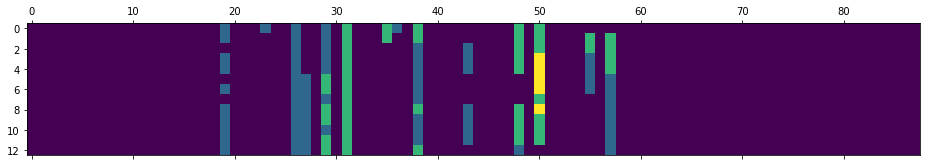

In [54]:
plt.matshow(note_record1)

Note: the double counting mentioned earlier shows up here in the different colors. It still will not cause problems for the code. In fact, in a way it represents the prominance of a particular note.
* To get certian notes to be detected, it was necesary to tweak the input settings. I had to reduce the segments to 3 per second and increase the sensitivity by decreasing the number to 75. This demonstrates the trade off between better time informantion from a larger number of segments vs better note information from a smaller number of segments.
* The actual notes that I played on the guitar for this chord were E2, B2, D3, G#3, B3, and E4. Interestingly, the G#3 and E4 are not very prominent in the sound wave, even when the segments are lengthened. Additionally, there are a significant amount of 'ghost notes' that appear in the sound even though I didn't explicitly play them. These are likely either higher harmonics of notes that I did play, some resonance from the instument itself, or some sort of interference pattern that results in what looks like another note. 

## Determining Key
A key is the set of notes used to form a basis for a piece of music. At a basic level, there are 12 major and minor keys (one major and minor key for each note). It turns out, however, that the notes which makeup the 24 keys overlap, producing only 12 distinct key signatures. There are more complicated keys that are less commonly used, but I will be limiting my scope to only the basic 12 key signatures mentioned.

Reference 
* https://hellomusictheory.com/learn/relative-keys/

I will make a function that inputs the 2D note array and prints the key it best matches to. The first step is to sum all of the notes in the 2D array, essentially collapsing it into a 1D array with the total number of notes detected stored in the correspoding note's location. Next, it creates 12 arrays representing the 12 keys with 1's in the locations for notes belonging to the key and 0's for the notes that are not in the key. Finally, to determine which key the data best matches, it multiplies the array with the note data in it to each of the key arrays it created and sums the result. Doing this will count all of the notes from the data belonging to each key respectively, and the result with the highest number will be the key that best matches the data.

In [55]:
def key_analyser(note_record): #this will determine the key of the music
    note_total = sum(note_record) #this collapses the 2D array into a 1D array with the sums of each note
        
    standard_keys = [0,0,0,0,0,0,0,0,0,0,0,0] #list for storing keys
    
    standard_keys[0] = [1,0,1,0] + 7*[1,1,0,1,0,1,0,1,1,0,1,0] #A_maj 
    standard_keys[1] = [1,1,0,1] + 7*[0,1,1,0,1,0,1,0,1,1,0,1] #As_maj
    standard_keys[2] = [0,1,1,0] + 7*[1,0,1,1,0,1,0,1,0,1,1,0] #B_maj
    standard_keys[3] = [1,0,1,1] + 7*[0,1,0,1,1,0,1,0,1,0,1,1] #C_maj
    standard_keys[4] = [0,1,0,1] + 7*[1,0,1,0,1,1,0,1,0,1,0,1] #Cs_maj
    standard_keys[5] = [1,0,1,0] + 7*[1,1,0,1,0,1,1,0,1,0,1,0] #D_maj
    standard_keys[6] = [0,1,0,1] + 7*[0,1,1,0,1,0,1,1,0,1,0,1] #Ds_maj
    standard_keys[7] = [1,0,1,0] + 7*[1,0,1,1,0,1,0,1,1,0,1,0] #E_maj
    standard_keys[8] = [1,1,0,1] + 7*[0,1,0,1,1,0,1,0,1,1,0,1] #F_maj
    standard_keys[9] = [0,1,1,0] + 7*[1,0,1,0,1,1,0,1,0,1,1,0] #Fs_maj
    standard_keys[10] = [1,0,1,1] + 7*[0,1,0,1,0,1,1,0,1,0,1,1] #G_maj
    standard_keys[11] = [0,1,0,1] + 7*[1,0,1,0,1,0,1,1,0,1,0,1] #Gs_maj

    key_sum = [0,0,0,0,0,0,0,0,0,0,0,0] #list for storing the counts of notes belonging to corresponding keys
    
    for i,key in enumerate(standard_keys):
        key_sum[i] = sum(note_total*key)
    
    result = key_sum.index(np.amax(key_sum)) #finds which index has the highest value
    
    #then prints the key that result corresponds to
    if result == 0: print('Key of A major / F# minor')
    if result == 1: print('Key of A# major / G minor')
    if result == 2: print('Key of B major / G# minor')
    if result == 3: print('Key of C major / A minor')
    if result == 4: print('Key of C# major / A# minor')
    if result == 5: print('Key of D major / B minor')
    if result == 6: print('Key of D# major / C minor')
    if result == 7: print('Key of E major / C# minor')
    if result == 8: print('Key of F major / D minor')
    if result == 9: print('Key of F# major / D# minor')
    if result == 10: print('Key of G major / E minor')
    if result == 11: print('Key of G# major / F minor')
        
    return

* Here is the result from a recording of me playing the beginning of Fur Elise on my keyboard. This part of Fur Elise is in the key of A minor.

Key of C major / A minor


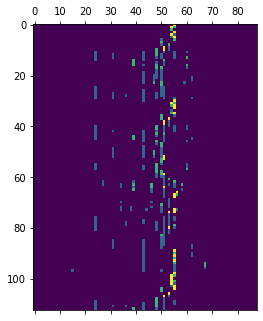

In [56]:
note_record2, time_record2 = note_analyser('furelise.txt', 5, 0.01, 100)
plt.matshow(note_record2)
key_analyser(note_record2)

This caputes almost all of the notes that I played, and consistantly guesses the correct key of the music even when different input values for segments, tolerance, and sensitivity are used.

* Here is the result from a recording of me playing the beginning of Bourre in E minor on guitar.

Key of G major / E minor


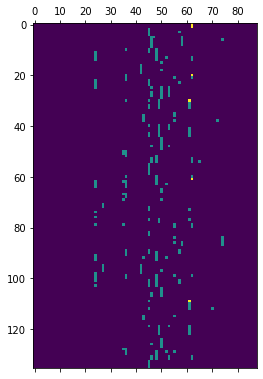

In [57]:
note_record2, time_record2 = note_analyser('bourre.txt', 10, 0.01, 100)
plt.matshow(note_record2)
key_analyser(note_record2)

Note: Unlike with the Fur Elise recording, it was necessary to tweak the inputs to get the correct key as the output. This is because there are a lot of harmonics and other unplayed notes from the guitar that are detected and skew the note counts towards another key. I was playing at most two notes at once for this recording, and there are segments in here with 4 or 5 detected notes. However, this is not a bad result. These extra notes are part of what gives the guitar its characteristic sound, and are clearly a major part of the sound wave that the guitar produced.
* Out of curiosity, I graphed a segment that had a lot of harmonics to see what it's wave and transform look like.

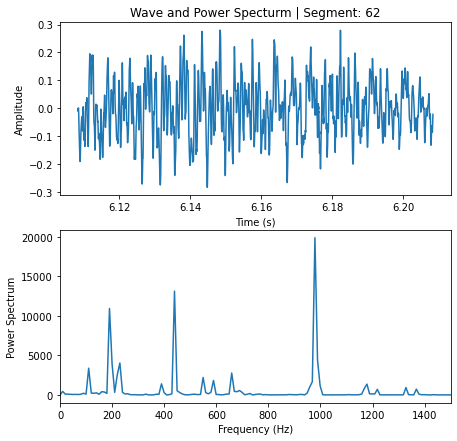

In [58]:
segment_graph('bourre.txt', 10, 62, 1500)

It can be seen from this graph that explicitly playing only two notes can produce a sound that is much more complex than just the two frequenceis added together.

## Conclusion
I have created code that can take raw audio data and figure out which musical notes make up the sound. After analyzing an entire piece of music, my code can also make a guess at which key it was played in. This process is entirely reliant on the Fourier transform and demonstrates the versitility of the Fourier transform as a tool for science. It also demonstrates some of the math involved in music, like how the frequencies of notes are determined by an exponential equation and every octave of a note has a power of 2 frequency difference.